### Auxillary Classifier GAN

This notebooks is a slight modifications to the excellent work from the public Github site of Chen Kai Xu from Chen Kai Xu  Tsukuba University.  see https://github.com/ChenKaiXuSan/ACGAN-PyTorch.  

For an acGan we assume that we have a class label for each image.   In our case the data has three categories: barred spiral  (class 0), elliptical (class 1) and spiral (class 2).   The discriminator is modified so that it not only returns the probability that the image is real, it also returns a guess at the class.  The generator takes an extra parameter to encourage it to generate an image of the class.   Let d = the number of classes (-1) then we have 


$$
G(v, c) \rightarrow  R^m ~~ with ~~ v \sim \mathcal{N}^k(0,1) ~~and~~ c \sim [0, d]
$$
$$
D: R^m \rightarrow [0,1] ~x~~ [0,d]
$$

The discriminator is now trained to minimize the error in true/false recognition but also the error in class recognition.  

In [3]:
# %% 
"""
wgan with different loss function, used the pure dcgan structure.
"""
import os 
import time
import torch
import datetime

import torch.nn as nn 
import torchvision
from torchvision.utils import save_image
from utils import *


This class is a substitute for the command line parameters.

In [18]:
class Config(object):
    def __init__(self):
        super(Config, self).__init__()
        self.model='acgan' 
        self.n_classes = 3
        self.img_size=64
        self.channels=3
        self.g_num=5
        self.z_dim=100
        self.g_conv_dim=64
        self.d_conv_dim=64
        self.lambda_gp=10.0
        self.version='actest'
        self.clip_value=0.01
        # Training setting
        self.epochs=5000 
        self.batch_size=32 
        self.num_workers=2
        # TTUR 
        self.g_lr=0.0001
        self.d_lr=0.0004 
        self.beta1=0.5
        self.beta2=0.999

        # using pretrained
        self.pretrained_model=None

        # Misc
        self.train=True
        self.parallel=False
        self.dataset='galaxy'
        self.use_tensorboard=False 
        # Path
        self.dataroot="C:/Users/denni/OneDrive/Docs9/gan/galaxies4" 
        self.log_path='./logs'
        self.model_save_path='./acmodels' 
        self.sample_path='./samples' 
        # Step size
        self.log_step=100
        self.sample_step=1000 
        self.model_save_step=1000
import os
import utils
config = Config()
print(config.model)      

acgan


In [6]:
#acgan structure.
#the network model architecture from the paper [ACGAN](https://arxiv.org/abs/1610.09585)

import torch
import torch.nn as nn

import numpy as np
from torch.nn.modules.activation import Sigmoid

In [8]:
# %%
class Generator(nn.Module):
    '''
    pure Generator structure
    '''    
    def __init__(self, image_size=64, z_dim=100, conv_dim=64, channels = 3, n_classes=3):
        
        super(Generator, self).__init__()
        self.imsize = image_size
        self.channels = channels
        self.z_dim = z_dim
        self.n_classes = n_classes

        self.label_embedding = nn.Embedding(self.n_classes, self.z_dim)
        self.linear = nn.Linear(self.z_dim, 768)

        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(768, 384, 4, 1, 0, bias=False),
            nn.BatchNorm2d(384),
            nn.ReLU(True)
        )

        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(384, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )

        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(256, 192, 4, 2, 1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )
        
        self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(192, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )

        self.last = nn.Sequential(
            nn.ConvTranspose2d(64, self.channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_emb = self.label_embedding(labels)
        gen_input = torch.mul(label_emb, z)

        out = self.linear(gen_input)
        out = out.view(-1, 768, 1, 1)

        out = self.deconv1(out)
        out = self.deconv2(out)
        out = self.deconv3(out)
        out = self.deconv4(out)
        
        out = self.last(out) # (*, c, 64, 64)

        return out

In [9]:
# %%
class Discriminator(nn.Module):
    '''
    pure discriminator structure
    '''
    def __init__(self, image_size = 64, conv_dim = 64, channels = 1, n_classes = 10):
        super(Discriminator, self).__init__()
        self.imsize = image_size
        self.channels = channels
        self.n_classes = n_classes

        # (*, c, 64, 64)
        self.conv1 = nn.Sequential(
            nn.Conv2d(self.channels, 16, 3, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5, inplace=False)
        )

        # (*, 64, 32, 32)
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, 1, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5, inplace=False)
        )

        # (*, 128, 16, 16)
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5, inplace=False)
        )
        
        # (*, 256, 8, 8)
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5, inplace=False)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5, inplace=False)
        )

        self.conv6 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5, inplace=False)
        )

        # output layers
        # (*, 512, 8, 8)
        # dis fc
        self.last_adv = nn.Sequential(
            nn.Linear(8*8*512, 1),
            # nn.Sigmoid()
            )
        # aux classifier fc 
        self.last_aux = nn.Sequential(
            nn.Linear(8*8*512, self.n_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, input):
        out = self.conv1(input)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)

        flat = out.view(input.size(0), -1)

        fc_dis = self.last_adv(flat)
        fc_aux = self.last_aux(flat)

        return fc_dis.squeeze(), fc_aux

In [10]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals


import torch
import torchvision.transforms as transform
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from tqdm import tqdm
import torch.nn.functional as F

from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

#the data collection is in a zipped file in the github directory
DATA_DIR = "C:/Users/denni/OneDrive/Docs9/gan/galaxies4"
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
stats = (.1, 0.1, 0.1), (.9, 0.9, 0.9)

def getdDataset(opt):
    dataset = ImageFolder(DATA_DIR, transform=T.Compose([
        T.Resize(config.img_size),
        T.CenterCrop(config.img_size), #sqaure from rectangle images
        T.ToTensor(),
        T.Normalize(*stats)]))
    
    dataloader = DataLoader(
        dataset,
        batch_size=opt.batch_size, 
        shuffle=True,
    )

    return dataloader

0 torch.Size([32, 3, 64, 64]) torch.Size([32])
tensor([2, 0, 0, 2, 0, 1, 2, 0, 0, 1, 0, 0, 0, 2, 0, 1, 2, 2, 2, 2, 1, 1, 2, 0,
        2, 0, 2, 1, 2, 0, 2, 1])


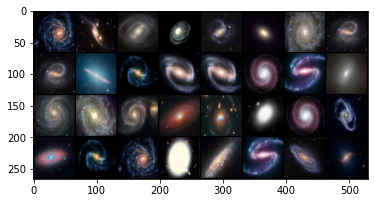

In [13]:
# data loader 
data_loader = getdDataset(config)
# look at a sample of the data set.

for i, (imgs, labels) in enumerate(data_loader):
    print(i, imgs.shape, labels.shape)
    print(labels)

    img = imgs[0]
    img = img.numpy()
    img = make_grid(imgs, normalize=True).numpy()
    img = np.transpose(img, (1, 2, 0))

    plt.imshow(img)
    plt.show()
    plt.close()
    break



In [14]:
# delete the exists path
del_folder(config.sample_path, config.version)
del_folder(config.log_path, config.version)

# create directories if not exist
make_folder(config.sample_path, config.version)
make_folder(config.log_path, config.version)
make_folder(config.sample_path, config.version + '/real_images')
make_folder(config.sample_path, config.version + '/fake_images')

In [15]:
# %% 
"""
wgan with different loss function, used the pure dcgan structure.
"""
import os 
import time
import torch
import datetime

import torch.nn as nn 
import torchvision
from torchvision.utils import save_image

In [22]:
# %%
class Trainer_acgan(object):
    def __init__(self, data_loader, config):
        super(Trainer_acgan, self).__init__()

        # data loader 
        self.data_loader = data_loader

        # exact model and loss 
        self.model = config.model

        # model hyper-parameters
        self.imsize = config.img_size 
        self.g_num = config.g_num
        self.z_dim = config.z_dim
        self.channels = config.channels
        self.n_classes = config.n_classes
        self.g_conv_dim = config.g_conv_dim
        self.d_conv_dim = config.d_conv_dim

        self.epochs = config.epochs
        self.batch_size = config.batch_size
        self.num_workers = config.num_workers 
        self.g_lr = config.g_lr
        self.d_lr = config.d_lr 
        self.beta1 = config.beta1
        self.beta2 = config.beta2
        self.pretrained_model = config.pretrained_model

        self.dataset = config.dataset 
        self.use_tensorboard = config.use_tensorboard
        # path
        self.image_path = config.dataroot 
        self.log_path = config.log_path
        self.sample_path = config.sample_path
        self.log_step = config.log_step
        self.sample_step = config.sample_step
        self.version = config.version

        # path with version
        self.log_path = os.path.join(config.log_path, self.version)
        self.sample_path = os.path.join(config.sample_path, self.version)

        if self.use_tensorboard:
            self.build_tensorboard()

        self.build_model()

    def train(self):
        '''
        Training
        '''

        # fixed input for debugging
        fixed_z = tensor2var(torch.randn(self.batch_size, self.z_dim)) # (*, 100)
        fixed_labels = tensor2var(torch.randint(0, self.n_classes, (self.batch_size,), dtype=torch.long))
        # fixed_labels = to_LongTensor(np.array([num for _ in range(self.n_classes) for num in range(self.n_classes)]))

        for epoch in range(self.epochs):
            # start time
            start_time = time.time()

            for i, (real_images, labels) in enumerate(self.data_loader):

                # configure input 
                real_images = tensor2var(real_images)
                labels = tensor2var(labels)
                
                # adversarial ground truths
                valid = tensor2var(torch.full((real_images.size(0),), 0.9)) # (*, )
                fake = tensor2var(torch.full((real_images.size(0),), 0.0)) #(*, )
                
                # ==================== Train D ==================
                self.D.train()
                self.G.train()

                self.D.zero_grad()

                # compute loss with real images 
                dis_out_real, aux_out_real = self.D(real_images)

                d_loss_real = self.adversarial_loss_sigmoid(dis_out_real, valid) + self.aux_loss(aux_out_real, labels)

                # noise z for generator
                z = tensor2var(torch.randn(real_images.size(0), self.z_dim)) # *, 100
                gen_labels = tensor2var(torch.randint(0, self.n_classes, (real_images.size(0),), dtype=torch.long))

                fake_images = self.G(z, gen_labels) # (*, c, 64, 64)
                dis_out_fake, aux_out_fake = self.D(fake_images) # (*,)

                d_loss_fake = self.adversarial_loss_sigmoid(dis_out_fake, fake) + self.aux_loss(aux_out_fake, gen_labels)

                # total d loss
                d_loss = d_loss_real + d_loss_fake

                d_loss.backward()
                # update D
                self.d_optimizer.step()

                # calculate dis accuracy
                d_acc = compute_acc(aux_out_real, aux_out_fake, labels, gen_labels)

                # train the generator every 5 steps
                if i % self.g_num == 0:

                    # =================== Train G and gumbel =====================
                    self.G.zero_grad()
                    # create random noise 
                    fake_images = self.G(z, gen_labels)

                    # compute loss with fake images 
                    dis_out_fake, aux_out_fake = self.D(fake_images) # batch x n

                    g_loss_fake = self.adversarial_loss_sigmoid(dis_out_fake, valid) + self.aux_loss(aux_out_fake, gen_labels)

                    g_loss_fake.backward()
                    # update G
                    self.g_optimizer.step()
            # end one epoch

            # print out log info
            if (epoch) % self.log_step == 0:
                elapsed = time.time() - start_time
                elapsed = str(datetime.timedelta(seconds=elapsed))
                print("Elapsed [{}], G_step [{}/{}], D_step[{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, Acc: {:.4f}"
                    .format(elapsed, epoch, self.epochs, epoch,
                            self.epochs, d_loss.item(), g_loss_fake.item(), d_acc))

            # sample images 
            if (epoch) % self.sample_step == 0:
                self.G.eval()
                # save real image
                save_sample(self.sample_path + '/real_images/', real_images, epoch)
                
                with torch.no_grad():
                    fake_images = self.G(fixed_z, fixed_labels)
                    # save fake image 
                    save_sample(self.sample_path + '/fake_images/', fake_images, epoch)
                    
                # sample sample one images
                save_sample_one_image(self.sample_path, real_images, fake_images, epoch)


    def build_model(self):

        self.G = Generator(image_size = self.imsize, z_dim = self.z_dim, conv_dim = self.g_conv_dim, channels = self.channels).cuda()
        self.D = Discriminator(image_size = self.imsize, conv_dim = self.d_conv_dim, channels = self.channels).cuda()

        # apply the weights_init to randomly initialize all weights
        # to mean=0, stdev=0.2
        self.G.apply(weights_init)
        self.D.apply(weights_init)
        
        # optimizer 
        self.g_optimizer = torch.optim.Adam(self.G.parameters(), self.g_lr, [self.beta1, self.beta2])
        self.d_optimizer = torch.optim.Adam(self.D.parameters(), self.d_lr, [self.beta1, self.beta2])

        # for orignal gan loss function
        self.adversarial_loss_sigmoid = nn.BCEWithLogitsLoss().cuda()
        self.aux_loss = nn.CrossEntropyLoss().cuda()

        # print networks
        print(self.G)
        print(self.D)



In [20]:
def compute_acc(real_aux, fake_aux, labels, gen_labels):
    # Calculate discriminator accuracy
    pred = np.concatenate([real_aux.data.cpu().numpy(), fake_aux.data.cpu().numpy()], axis=0)
    gt = np.concatenate([labels.data.cpu().numpy(), gen_labels.data.cpu().numpy()], axis=0)
    d_acc = np.mean(np.argmax(pred, axis=1) == gt)

    return d_acc

In [23]:
if config.train:
    if config.model == 'acgan':
        trainer = Trainer_acgan(data_loader, config)
    trainer.train()


Generator(
  (label_embedding): Embedding(3, 100)
  (linear): Linear(in_features=100, out_features=768, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(768, 384, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(384, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (deconv3): Sequential(
    (0): ConvTranspose2d(256, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (deconv4): Sequential(
    (0): ConvTranspose2d(192, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum

Elapsed [0:00:00.716387], G_step [4700/5000], D_step[4700/5000], d_loss: 3.4229, g_loss: 5.5281, Acc: 0.9844
Elapsed [0:00:00.737231], G_step [4800/5000], D_step[4800/5000], d_loss: 3.4908, g_loss: 5.3828, Acc: 0.9844
Elapsed [0:00:00.703356], G_step [4900/5000], D_step[4900/5000], d_loss: 3.4775, g_loss: 5.5364, Acc: 1.0000


In [24]:
def save_samples(index, fake_images, latent_labels, show=True):
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(fake_images, 'C:/Users/denni/OneDrive/Docs15/data/'+fake_fname, nrow=4)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(16,16))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=4).permute(1, 2, 0))

In [63]:
#as an experiment let's ask the generator to create an image consisting of 32 eliptical galaxies

eval_noise_ = np.random.normal(0, 1, (config.batch_size, config.z_dim))#generating noise by random sampling from a normal distribution
#eval_label_=np.random.randint(0,3,batch_size)#generating labels for the entire batch
label_ = np.zeros(config.batch_size)+2

eval_noise=((torch.from_numpy(eval_noise_)).float())        
eval_label = ((torch.from_numpy(label_)).long()).cuda()
print(eval_label)
eval_noise=eval_noise.cuda()
fake_images = trainer.G(eval_noise, eval_label)
noise_image=trainer.G(eval_noise, eval_label)


tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')


In [64]:
# now see  how the discriminator classifies the fake images
source_,class_=trainer.D(fake_images)
#print(class_)
class_error=trainer.aux_loss(class_,eval_label)
z = []
for i in range(32):
    y = class_[i].tolist()
    z.append(y.index(max(y)))
print(z)
print(eval_label.tolist())
score = 0.0
for i in range(32):
    if z[i]==eval_label.tolist()[i]:
        score +=1.0
print(score/32.0)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
1.0


In [58]:
# a function that will generate images of a given class.
def make_by_shape(x):
    eval_noise_ = np.random.normal(0, 1, (config.batch_size, config.z_dim))#generating noise by random sampling from a normal distribution
    label_ = np.zeros(config.batch_size)+x
    eval_noise=((torch.from_numpy(eval_noise_)).float()).cuda()        
    eval_label = ((torch.from_numpy(label_)).long()).cuda()
    pics = trainer.G(eval_noise, eval_label)
    img = pics.cpu()
    img = img.detach()
    print(img.shape)
    imgs = []
    for i in range(32):
        imgs.append(img[i])
    #print(imgs)
    img = make_grid(imgs, normalize=True).numpy()
    img = np.transpose(img, (1, 2, 0))

    plt.imshow(img)
    plt.show()
    plt.close()

torch.Size([32, 3, 64, 64])


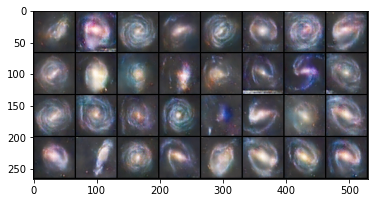

In [68]:
#make barred spiral
make_by_shape(0)

torch.Size([32, 3, 64, 64])


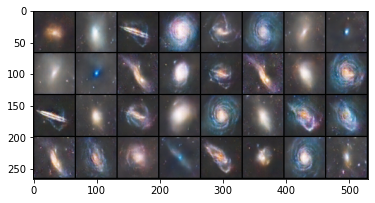

In [72]:
#make eliptical
make_by_shape(1)

torch.Size([32, 3, 64, 64])


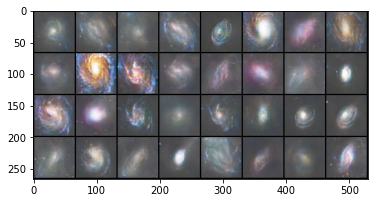

In [74]:
#make spiral
make_by_shape(2)